# Introduction: HST WFC3 Free Retrieval Transmission/Transit Tutorial  

Welcome to the transmission spectrum model/retrieval tutorial!

For this particular setup, the atmosphere is parameterized within the classic "free retrieval" framework.  In the free retrieval, typically, molecular/atomic abundances are assumed to be constant with altitude and chemically un-related (e.g., any abundance combinations are allowed). In principle, we can retrieve anything with an opacity (cross-sections, CK-coefficients). This tuotiral/code has these opacities for H2O,  CH4,  CO,  CO2, NH3,   HCN,   H2S,  PH3  C2H2, C2H6,  Na,    K,   TiO,   VO,   FeH,  H,    H2,   He,   e-, H- either through "line" or "continuum" opacities (e.g., H- free-free dependes on both the e- and H abundances).  Here we will assume any remaining gas is H2+He (at solar He/H2 ratio). This may not be a good assumption for ultra hot Jupiters, where H becomes dominent, or for very high metallicity objects where other species like H2O, CO2, N2, or CO become major background gases.  Free retrievals tend to work best in the "run-of-the-mill-hot-but-not-too-hot-Jupiter" realm.  Be weary, however, as free retrievals can trick one into a good fit with seemingly unphysical solutions.  None-the-less, they do provide some insight.

For the temperature profile, here, we assume the 3-parameter temperature  Guillot 2010/Parmentier et al. 2014 analytic formulism (see Line et al. 2013a for implementation details).     

The transmission spectrum routine closely follows the equations (and figure) in Tinetti et al. 2012 (as described in the tutorial text).  Instead of using line-by-line, or "sampled" cross-sections, this implementation uses the "correlated-K" method (see Lacis & Oinas 1990, or more recently Amundsen et al. 2017). Correlated-K is advantageous as it preserves the wavelength bin"integrated"  precision as line-by-line but with far less demanding computation.    See the "opacity" tutorial for more details on how correlated-K works. 

There are two different cloud prescriptions built in.  The first is the Ackerman & Marley 2001 "eddy-sed" approach that self-consistently computes the vertical particle size distribution given a sedimentation factor, $f_{sed}$ and an eddy mixing factor (K$_{zz}$) from some cloud base pressure and intrinsic condensate mixing ratio.  The classic "power-law haze" and "grey cloud" prescripton is also included.

This specific notebook goes through the steps to generate the forward model, and illustrate how to actually perform the free retrieval. However, the retrievals are bust run on a compute cluster or a node with more than 4 cores.  We will use the "benchmark" system, WASP-43b as our example utilizing the HST WFC3 data presented in Kreidberg et al. 2014b.

Software Requirements: This runs in the python 3 anaconda environment.  It is also crucial that anaconda numba is installed as many of the routines are optimized using numba's "@jit" decorator (http://numba.pydata.org/). 


# Import Routines, Load Opacities-------------------------------------  

This first segment loads in the routines from fm.py and the correlated-K coefficients.  There are two sets of correlated-K coefficients (which I've called "xsecs" here).  There are ones taylored for HST WFC3+STIS (xsects_HST function in fm.py) and JWST (xsects_JWST in fm.py).  The WFC3+STIS correlated-K coefficients are generated at an R=200 longwards of 1 $\mu$m (up to 5$\mu$m and R=500 from 0.3 - 1 $\mu$m.  Note...these *are not sampled cross-sections* so each resolution element at that R is correctly computed and matches line-by-line when binned to that same R.

Note that the "core" set of routines are all in fm.py.  If you want to know more about what is in the sausage, look into fm.py.  

In [1]:
#import all of the functions in fm, namely, the CK-coefficients (may take a minute)
from fm import *
%matplotlib notebook

#preload CK-coeffs--a giant array/variable to be passed--inputs are lower wavenumber, upper wavenumber
#between 2000 and 30000 cm-1 for HST--R=200 > 1 um, then R=500 < 1 um 
#to convert between microns and wavenumbers-- wavelength [um] = 10,000/wavenumber [cm-1]
#make sure xsec wavenumber/wavelength range is *larger* than data wavelength range
xsecs=xsects_HST(2000, 30000)
#xsecs=xsects_JWST(1000, 10000)


/Users/michaelline/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/michaelline/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaelline/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cross-sections Loaded


# Setup Atmospheric Parameters to Generate a Spectrum -------------------------

This segement defines the various atmospheric quantities and assignes them values for the generation of a simple transmission spectrum.  A description of each parameter along with a reasonable range of values is given as a comment following the assigned value. All of the parameters are then put into the parameter "state-vector" array, x.

In [2]:
#setup "input" parameters. We are defining our 1D atmosphere with these
#the parameters
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp=1.036  #Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.667 # #Stellar Radius in Solar Radii
M =2.034  #Mass in Jupiter Masses
D=0.01526   #semimajor axis in AU

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=1400     #Irradiation temperature as defined in Guillot 2010
logKir=-1.5  #TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
logg1=-0.7     #single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
Tint=200 #interior temperature...this would be the "effective temperature" if object were not irradiated

#log Gas abundances
H2O=-4.
CH4=-10.
CO=-4.  
CO2=-10. 
NH3=-10.  
N2=-4.   
HCN=-10.   
H2S=-5.  
PH3=-6.  
C2H2=-10. 
C2H6=-10. 
Na=-6.    
K=-7.   
TiO=-10.   
VO=-10.   
FeH=-10.  
H=-10.     
em=-10. 
hm=-10.

#Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR=-5.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

#simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
#(most are just made up anyway since we don't really understand all of the micro-physics.....)
logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
logRayAmp = -30  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

#10 bar radiuss scaling param (only used in transmission)
xRp=0.991

#stuffing all variables into state vector array
x=np.array([Tirr, logKir,logg1,Tint, 0, 0, 0,0, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
#gas scaling factors to mess with turning on various species
#set to "0" to turn off a gas. Otherwise keep set at 1
#thermochemical gas profile scaling factors
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([H2O,CH4,CO,CO2,NH3,N2,HCN,H2S,PH3,C2H2,C2H6,Na,K,TiO,VO ,FeH,H,-50.,-50.,em, hm,-50.]) #

# Load in Transmission Data Set 



In [3]:
#WASP43b transmission spectrum from kreidberg et al. 2014...a 3 column ascii file
wlgrid, y_meas, err=np.loadtxt('w43b_trans.txt').T


# Generate Model Atmosphere & Transmission Spectrum -------------------------  

Here we call the forward model routine "fx" (think F(x)) from fm.py.  fx controls the input values and calls the relevent functions to compute the transmission spectrum.  The inputs into fx are the parameter state vector, "x", the  data wavelength grid, "wlgrid", the gas scaling factors (for turning off particular gases), "gas_scale", and the correlated-K tables, "xsects".  Fx then returns the simulated model spectrum ($(R_p/R_{\star})^2$) at the native CK-table resolution, "y_mod", the native wavenumber grid, "wno", the data wavelength grid binned model spectrum, "y_binned".  The "atm" array contains the generated temperature-pressure profile and gas mixing ratio profiles generated under the chemically consistent assumption. 

In [4]:
#calling forward model, fx. This will produce the (Rp/Rstar)^2 spectrum....
y_binned,y_mod,wno,atm=fx_trans_free(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry
print('DONE')

DONE


# Plotting the Model Atmosphere & Transmission Spectrum  ---------------

Self-explanatory...

# Plot Model Atmosphere  

Spaghetti plot of the model atmosphere (this one is really boring since the abundances are forced constant with altitude...).

<IPython.core.display.Javascript object>


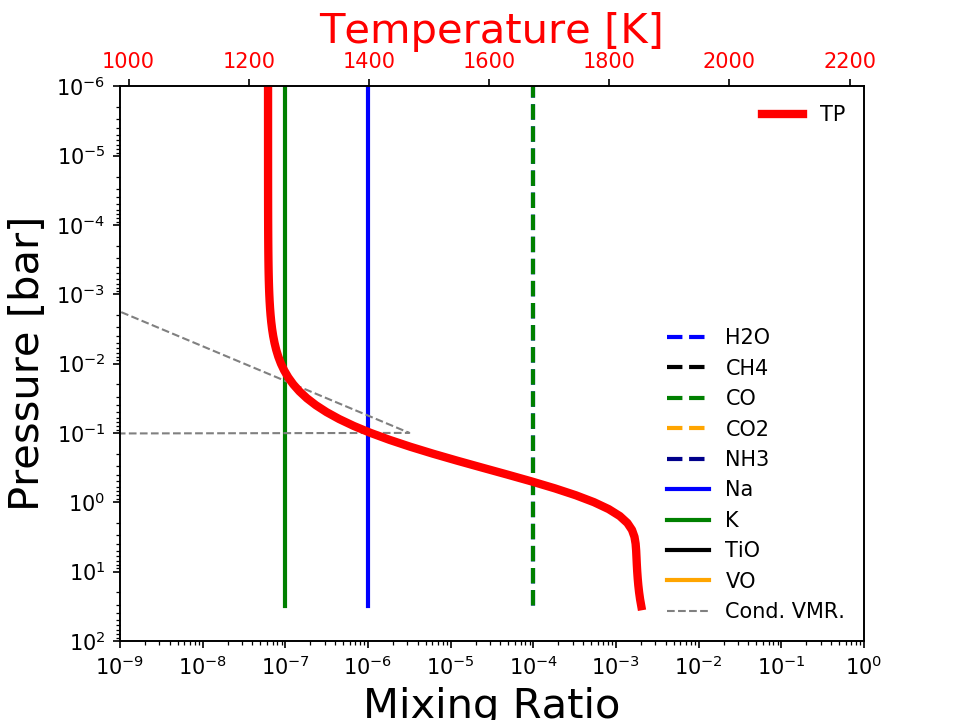

In [5]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter
%matplotlib notebook

#unpacking variables
#P is in bars
#T is in K
#H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He are gas mixing ratio profiles
#qc is the condensate abundance profile given an "f_sed" value and cloud base pressure
#r_eff is the effective cloud droplet radius given (see A&M 2001 or Charnay et al. 2017)
#f_r is the mixing ratio array for each of the cloud droplet sizes.
P,T, H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He,H,e, Hm,qc,r_eff,f_r=atm


fig2, ax1=subplots()
#feel free to plot whatever you want here....
ax1.semilogx(H2O,P,'b',ls='--',lw=2,label='H2O')
ax1.semilogx(CH4,P,'black',ls='--',lw=2,label='CH4')
ax1.semilogx(CO,P,'g',ls='--',lw=2,label='CO')
ax1.semilogx(CO2,P,'orange',ls='--',lw=2,label='CO2')
ax1.semilogx(NH3,P,'darkblue',ls='--',lw=2,label='NH3')
ax1.semilogx(Na,P,'b',lw=2,label='Na')
ax1.semilogx(K,P,'g',lw=2,label='K')
ax1.semilogx(TiO,P,'k',lw=2,label='TiO')
ax1.semilogx(VO,P,'orange',lw=2,label='VO')
ax1.semilogx(qc,P,'gray',lw=1,ls='--',label='Cond. VMR.')  #<---- A&M Cloud Condensate VMR profile (not droplets)

ax1.set_xlabel('Mixing Ratio',fontsize=20)
ax1.set_ylabel('Pressure [bar]',fontsize=20)
ax1.semilogy()
ax1.legend(loc=4,frameon=False)
ax1.axis([1E-9,1,100,1E-7])

#plotting TP profile on other x-axis
ax2=ax1.twiny()
ax2.semilogy(T,P,'r-',lw='4',label='TP')
ax2.set_xlabel('Temperature [K]',color='r',fontsize=20)
ax2.axis([0.8*T.min(),1.2*T.max(),100,1E-6])
for tl in ax2.get_xticklabels(): tl.set_color('r')
ax2.legend(loc=1,frameon=False)

savefig('./plots/atmosphere_transmission_WFC3_FREE.pdf',fmt='pdf')
show()
#close()





# Plot Transmission Spectrum Model and Data 


<IPython.core.display.Javascript object>


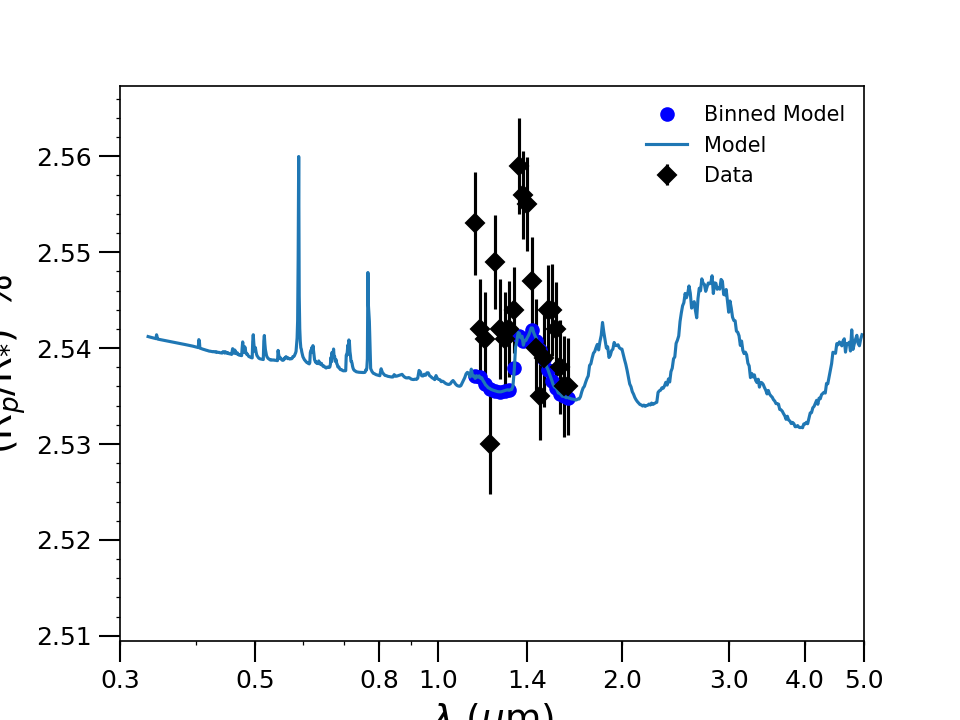

In [6]:
#finally doing some plotting
#and the usual matplotlib shenanigans
ymin=np.min(y_binned)*1E2*0.99
ymax=np.max(y_binned)*1E2*1.01
fig1, ax=subplots()
xlabel('$\lambda$ ($\mu$m)',fontsize=18)
ylabel('(R$_{p}$/R$_{*}$)$^{2} \%$',fontsize=18)
minorticks_on()
errorbar(wlgrid, y_meas*100, yerr=err*100, xerr=None, fmt='Dk', label='Data')
plot(wlgrid, y_binned*1E2,'ob',label='Binned Model')
plot(1E4/wno, y_mod*1E2, label='Model')
ax.set_xscale('log')
ax.set_xticks([0.3, 0.5,0.8,1,1.4, 2, 3, 4, 5])
ax.axis([0.3,5,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=10,width=1,labelsize='large',which='major')
legend(frameon=False)
savefig('./plots/transmission_spectrum_WFC3_FREE.pdf',fmt='pdf')
show()
#close()


# Play around with Transmission Spectrum-------------------------------------

# Explore cloud contribution

<IPython.core.display.Javascript object>


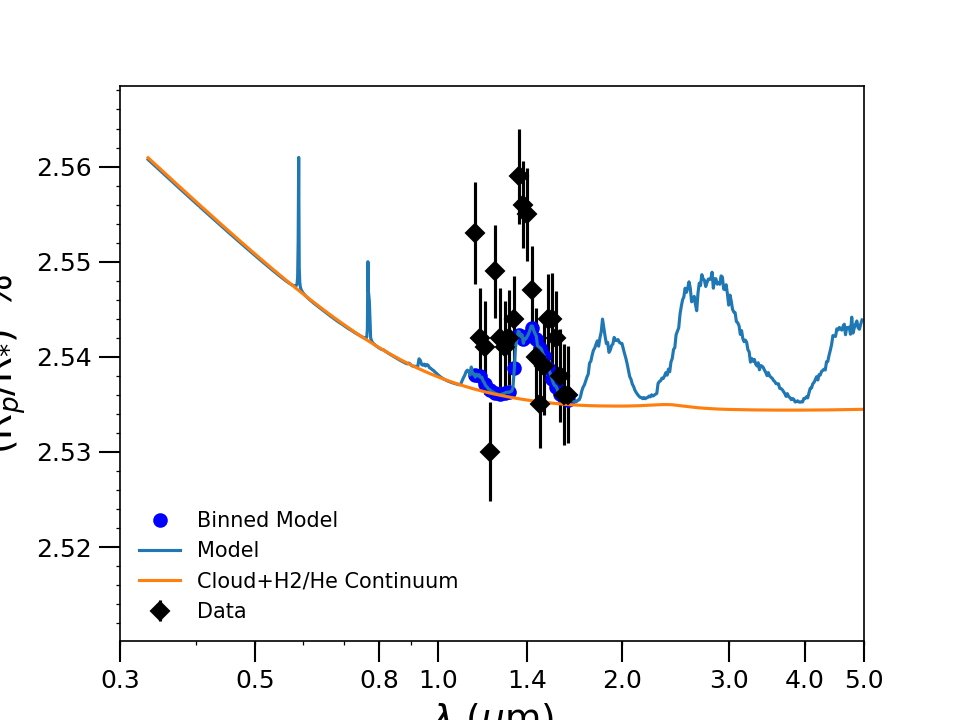

In [7]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter

#log Gas abundances
H2O=-4.
CH4=-10.
CO=-4.  
CO2=-10. 
NH3=-10.  
N2=-4.   
HCN=-10.   
H2S=-5.  
PH3=-6.  
C2H2=-10. 
C2H6=-10. 
Na=-6.    
K=-7.   
TiO=-15.   
VO=-15.   
FeH=-15.  
H=-10.     
em=-10. 
hm=-10.

#Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR=-15.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

#simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
#(most are just made up anyway since we don't really understand all of the micro-physics.....)
logKcld = -30  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
logRayAmp =2  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
RaySlope = 4  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

#10 bar radiuss scaling param (only used in transmission)
xRp=0.991

#stuffing all variables into state vector array
x=np.array([Tirr, logKir,logg1,Tint, 0, 0, 0,0, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
#gas scaling factors to mess with turning on various species
#set to "0" to turn off a gas. Otherwise keep set at 1
#thermochemical gas profile scaling factors
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([H2O,CH4,CO,CO2,NH3,N2,HCN,H2S,PH3,C2H2,C2H6,Na,K,TiO,VO ,FeH,H,-50.,-50.,em, hm,-50.]) #

y_binned,y_mod,wno,atm=fx_trans_free(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry

gas_scale2=np.ones(len(gas_scale))*gas_scale
gas_scale2[0:-1]=-50
y_binned2,y_mod2,wno2,atm2=fx_trans_free(x,wlgrid,gas_scale2, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry


ymin=np.min(y_binned)*1E2*0.99
ymax=np.max(y_binned)*1E2*1.01
fig1, ax=subplots()
xlabel('$\lambda$ ($\mu$m)',fontsize=18)
ylabel('(R$_{p}$/R$_{*}$)$^{2} \%$',fontsize=18)
minorticks_on()
errorbar(wlgrid, y_meas*100, yerr=err*100, xerr=None, fmt='Dk', label='Data')
plot(wlgrid, y_binned*1E2,'ob',label='Binned Model')
plot(1E4/wno, y_mod*1E2, label='Model')
plot(1E4/wno, y_mod2*1E2,label='Cloud+H2/He Continuum')
ax.set_xscale('log')
ax.set_xticks([0.3, 0.5,0.8,1,1.4, 2, 3, 4, 5])
ax.axis([0.3,5,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=10,width=1,labelsize='large',which='major')
legend(frameon=False)
show()
#close()



# Time to Get to the "Retrieval" ------------------------------------- 

The "retrieval" is performed using the DYNESTY (https://dynesty.readthedocs.io/en/latest/index.html) nested sampling suite.  It's basically like all of the others (e.g., multinest, pymultnest, nestle etc.), though it's more flexible in terms of sampling methods optimized for certain numbers of parameters.  This example just uses "generic" settings.

In [8]:
#set up a "dynest" nested sampling run--see https://dynesty.readthedocs.io/en/latest/index.html
#a super cool useful comparision of all MCMC/Multinests out there...
#http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/
#(feel free to mix and match samplers--probably not a bad idea...)
#for safty, just reloading everything again
import numpy as np
from matplotlib import pyplot as plt
import dynesty
from multiprocessing import Pool
from fm import *
import pickle
#load crosssections between wnomin and wnomax
xsecs=xsects_HST(6000,9400)  #make sure this range is *larger* than the data wavelength grid (but not by too much)
#6000 cm-1 (1.68 um) to 9400 cm-1 (1.06 um)

/Users/michaelline/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaelline/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cross-sections Loaded


# Defining log-likelihood function
This computes "chi-square" log-likelihood function.  The input value is "theta" which is the same as "x"--the parameter state vector, though just for the parameters we care about. These can be a sub-set of the full "x" defined above.  The first block defines a bunch of parameters--same as what gets passed into fx--to a generic default value.  Thes parameter values get overridden with the values in the "theta (parameters to retrieve) vector. In this particular example only Tirr, H2O,CO,NH3,CH4, logKcld, xRp are retrieved.  All other values passed into fx are assigned the other values.  

In [9]:
#defining log-likelihood function
# log-likelihood
def loglike(theta):

    #setting default parameters---will be fixed to these values unless replaced with 'theta'
    #planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
    Rp= 1.036#0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar=0.667#0.598   #Stellar Radius in Solar Radii
    M =2.034#1.78    #Mass in Jupiter Masses

    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    Tirr=1400#1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
    logKir=-5  #TP profile IR opacity controlls the "vertical" location of the gradient
    logg1=0.0     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
    Tint=0.
    
    #A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
    logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
    fsed=3.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
    logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
    logCldVMR=-25.0 #cloud fraction
    
    #simple 'grey+rayleigh' parameters--non scattering--just pure extinction
    logKcld = -40
    logRayAmp = -30
    RaySlope = 0
    
    H2O=-15.
    CH4=-15.
    CO=-15.  
    CO2=-15. 
    NH3=-15.  
    N2=-15.   
    HCN=-15.   
    H2S=-15.  
    PH3=-15.  
    C2H2=-15. 
    C2H6=-15. 
    Na=-15.    
    K=-15.   
    TiO=-15.   
    VO=-15.   
    FeH=-15.  
    H=-15.     
    em=-15. 
    hm=-15.

    
    #unpacking parameters to retrieve (these override the fixed values above)
    Tirr, H2O,CO,NH3,CH4, logKcld, xRp=theta
   
    ##all values required by forward model go here--even if they are fixed
    x=np.array([Tirr, logKir,logg1, Tint,0,0,0,0, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
    # 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
    #H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
    gas_scale=np.array([H2O,CH4,CO,CO2,NH3,N2,HCN,H2S,PH3,C2H2,C2H6,Na,K,TiO,VO ,FeH,H,-50.,-50.,em, hm,-50.]) #
    foo=fx_trans_free(x,wlgrid,gas_scale,xsecs)
    y_binned=foo[0]
    
    loglikelihood=-0.5*np.sum((y_meas-y_binned)**2/err**2)  #your typical "quadratic" or "chi-square"
    
    return loglikelihood


# Defining the Prior Function
Nested samplers use this "cube" concept whereby all of the parameter values are transformed on the interval [0,1]. This makes the sampling more-or-less scale indepenent.  The prior_transform function maps those back onto the actual parameter value ranges we want.  In this case, the prior ranges are all uniform over the range as defined here. Live points will be drawn from this hypercube uniformly.  These "live point" parameter values are then assesed by the log-likelihood function.    

In [10]:
#defining prior cube (cube is a standard multi-nest way of doing priors)
def prior_transform(utheta):
    Tirr, H2O,CO,CO2,CH4, logKcld, xRp=utheta
    #uniform prior ranges--each "variable", say Tirr is sampled over the interval [0,1]--the numbers here transform that
    Tirr = 1900 * Tirr + 100  #Tirr uniform from 400 - 3000K (add the lower value to the multiplier to get upper bound)
    H2O=12*H2O-12
    CO=12*CO-12
    CO2=12*CO2-12
    CH4=12*CH4-12
    logKcld=20*logKcld-45
    xRp=1*xRp+0.5

    return Tirr, H2O,CO,CO2,CH4, logKcld, xRp




# Loading in Data and Setting up Nested Sampling Parameters
This segment first loads in the "3 column" data file...Here it is just a pickle, but this could be replaced with a 3-column ascii file read in--wavelength grid, data values, error bars.  The other knobs are self-explanatory.  The number of live points is "problem dependent".  Some problems can get away with less. I wouldn't go below 100.  It's safer to use more (e.g., just like walkers in emcee).  For "real science" I prefer 1000+ live points to make sure the posterior is well sampled and no modes are missed.  Of course, this takes longer to run, but no sense in getting the the wrong answer faster!

In [11]:
#setting up other dynesty run params and loading in the data
#WASP43b transmission spectrum...a 3 column ascii file
wlgrid, y_meas, err=np.loadtxt('w43b_trans.txt').T
outname='./OUTPUT/dyn_output_trans_WFC3_FREE.pic'  #dynesty output file name (saved as a pickle)
Nparam=7  #number of parameters--make sure it is the same as what is in prior and loglike
Nproc=4  #number of processors for multi processing--best if you can run on a 12 core+ node or something
Nlive=500 #number of nested sampling live points


# Running Nested Sampler
This calls the Nested Sampler function to compute the posterior.  This may take a few hours depending on the number of parameters and number of live points.

In [ ]:
#running the "standard" nested sampler.  Again, see https://dynesty.readthedocs.io/en/latest/index.html for details
#depending on the number of live points (I like lots, usually 1000+, but I'm paranoid), number of params, and number of
#processors on your computer, this could take some time. -- your computer will make loud noises..1-2 hours with 4 cores
#in real life, you should probably run this on a multi-core machine (8+)
#in really real life, you should probably use pymultinest...it tends to "converge" faster with fewer likelihood
#evaluations than does dynest, even with the same number of live points (see: https://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/)
#e.g., when I ran this with 56 cores (2x28 core nodes) with multinest it took ~20 min.
import time
pool = Pool(processes=Nproc)
dsampler = dynesty.NestedSampler(loglike, prior_transform, ndim=Nparam,
                                        bound='multi', sample='auto', nlive=Nlive,
                                        update_interval=3., pool=pool, queue_size=Nproc)
#this executes and runs it
t1=time.time()
dsampler.run_nested()
t2=time.time()
print("Run Time:", t2-t1)
#extracting results from sampler object
dres = dsampler.results
#dumping as a pickle
pickle.dump(dres,open(outname,'wb'))  
#some real time dynesty output/status will pop up down here (this one took 51931 lnL calls over 4309s = 1.2 hrs)

# Plotting Corner Plot
Plots the corner plots and spectral fit plot. Note: All of the plotting below can be used for a "previously" generated run. Just start here and load in the sampler output.

ln(Z)=  -26.070611115262167


<IPython.core.display.Javascript object>


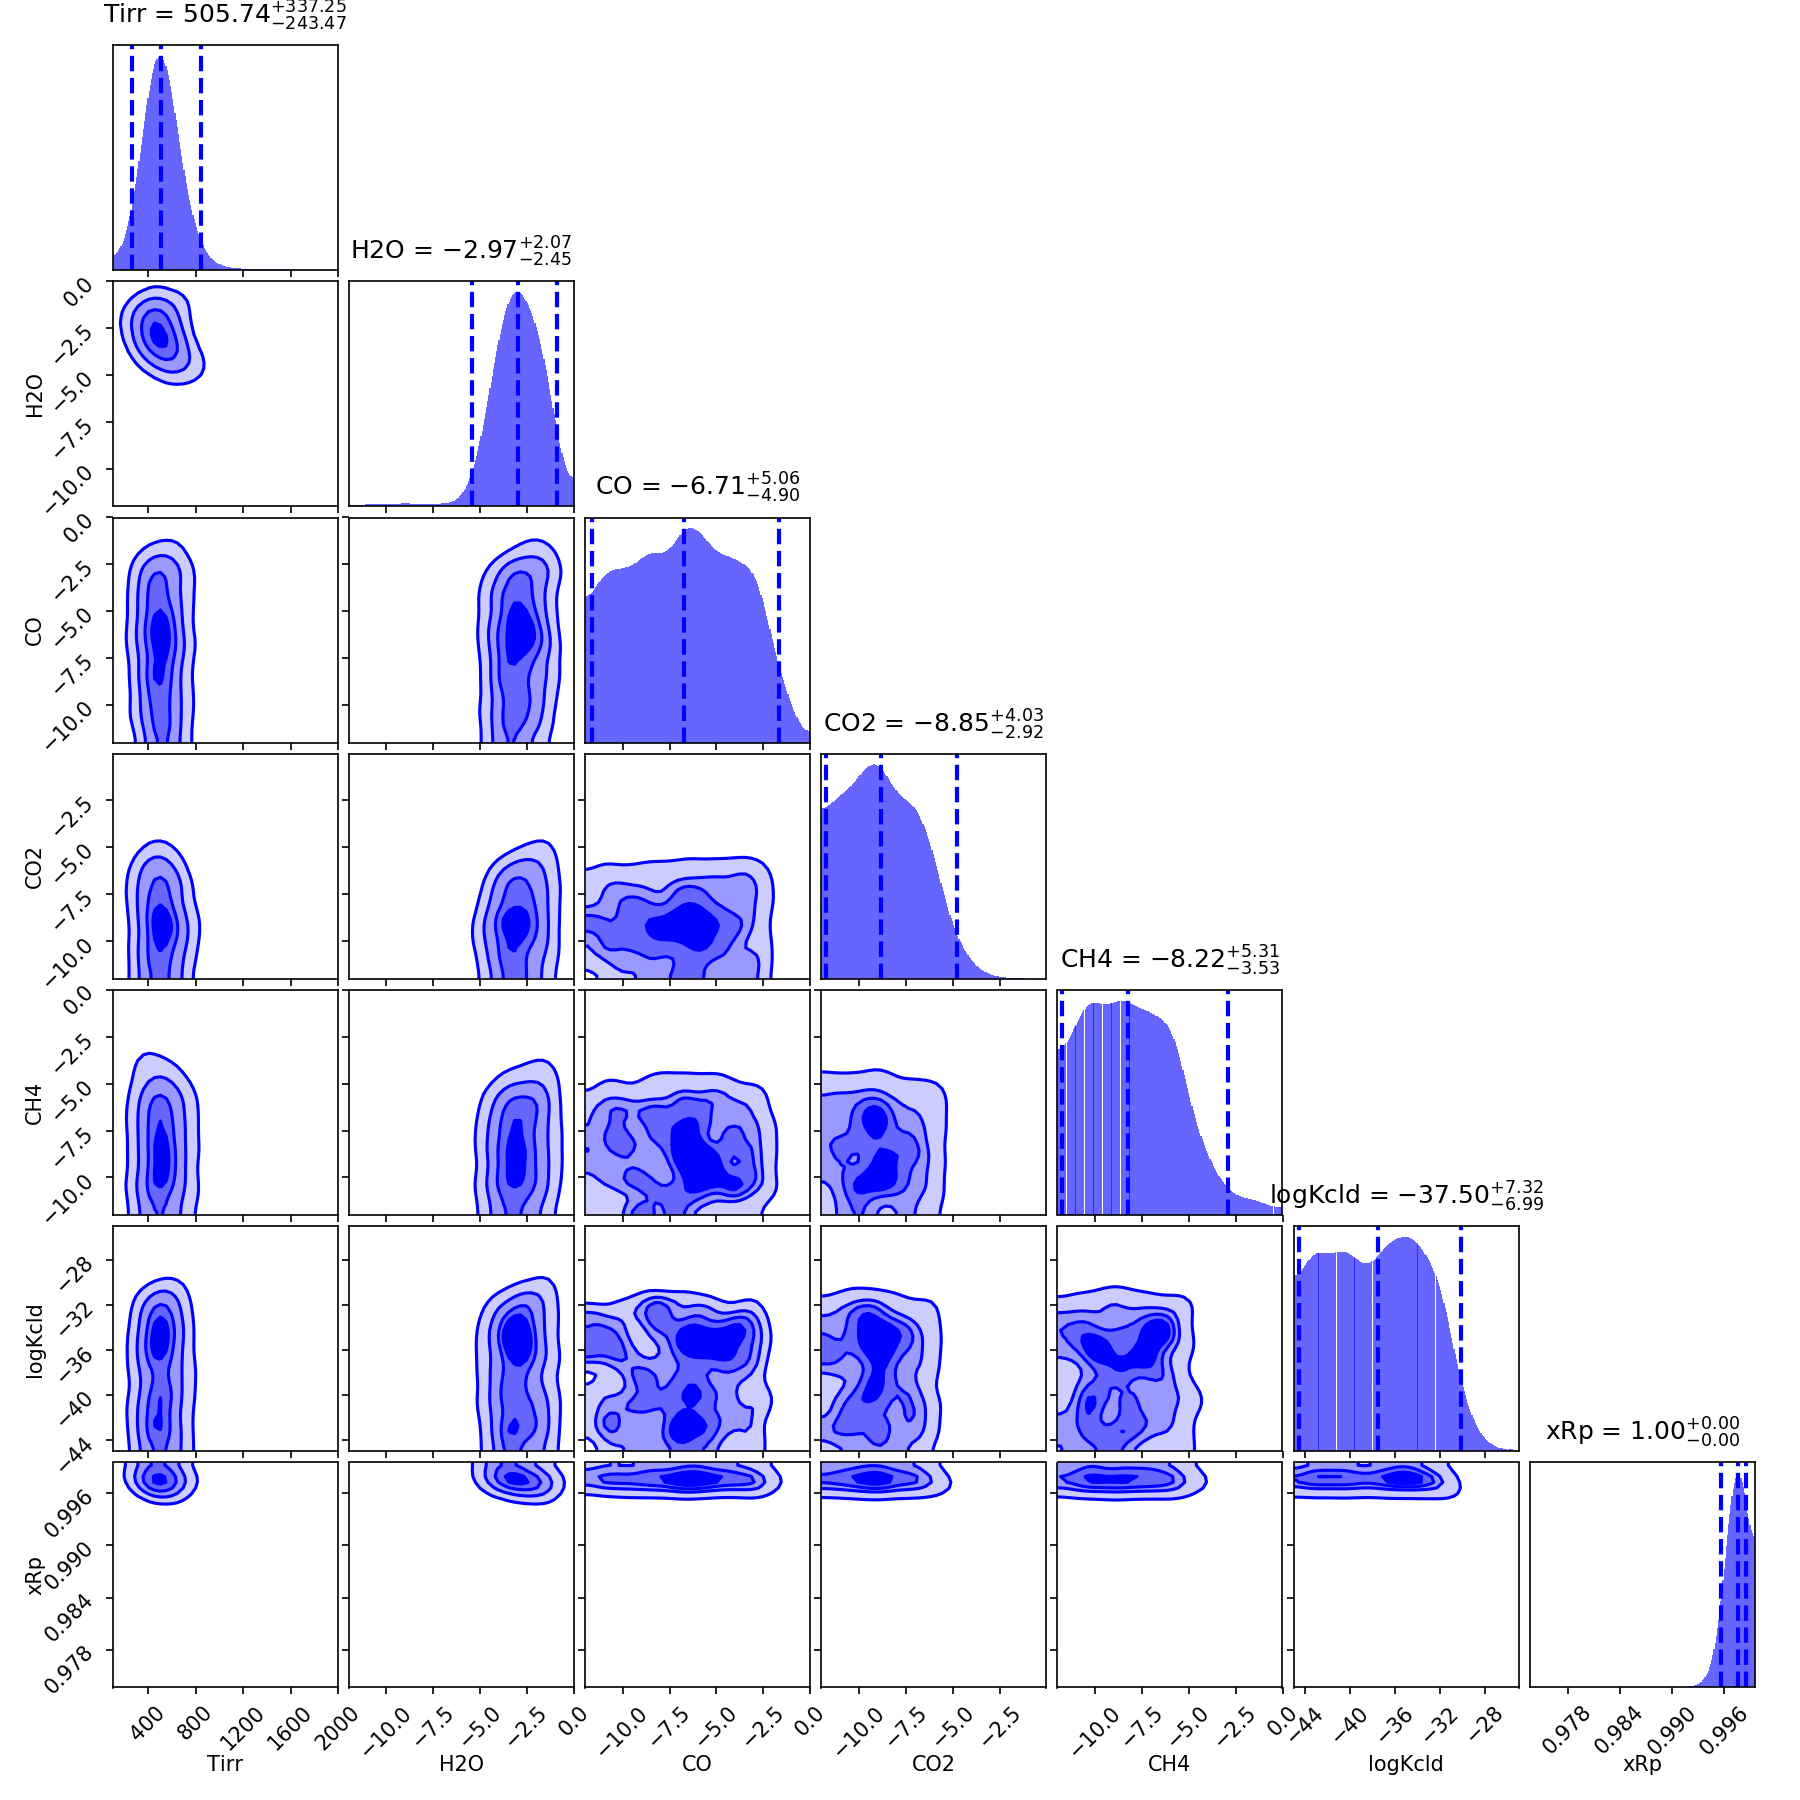

In [22]:
#plotting dynest runs corner plot
from matplotlib import pyplot as plt
from dynesty import plotting as dyplot
import pickle


labels=['Tirr', 'H2O', 'CO', 'CO2', 'CH4' ,'logKcld','xRp']

#import past run 
#samples=pickle.load(open('dyn_output_100LP.pic','rb')) #an example 100 live point run
samples=pickle.load(open('./OUTPUT/dyn_output_trans_WFC3_FREE.pic','rb')) 
#samples=pickle.load(open('dyn_output_1000LP.pic','rb'))  #an example 1000 live point run

#printing evidence:
print('ln(Z)= ', samples.logz[-1])

# corner plot
#NOTE...DEFAULT CONFIDENCE INTERVAL IS THE 95%!!!
fig, axes = dyplot.cornerplot(samples,smooth=0.05, color='blue',show_titles=True, labels=labels,title_kwargs={'y': 1.04}, fig=plt.subplots(7, 7, figsize=(12, 12)))
plt.savefig('./plots/Dynesty_WFC3_free_stair_pairs.pdf',fmt='pdf')
plt.show()
#plt.close()




# Plotting Spectral Fits
Generating spectra from parameters of a subset of samples drawn from the posterior.  These spectra, as always, are then summarized with their median, 1-, 2-, sigma confidence intervals.  

In [13]:
import numpy as np
xsecs=xsects_HST(2000, 30000)

Nspectra=200

#loading in data again just to be safe
wlgrid, y_meas, err=np.loadtxt('w43b_trans.txt').T


#setting up default parameter values--SET THESE TO SAME VALUES AS IN LOG-LIKE FUNCTION
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
#setting default parameters---will be fixed to these values unless replaced with 'theta'
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp= 1.036#0.930#*x[4]# Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.667#0.598   #Stellar Radius in Solar Radii
M =2.034#1.78    #Mass in Jupiter Masses

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=1400#1500#x[0]#544.54 #terminator **isothermal** temperature--if full redistribution this is equilibrium temp
logKir=-1.5  #TP profile IR opacity controlls the "vertical" location of the gradient
logg1=-0.7     #single channel Vis/IR opacity. Controls the delta T between deep T and TOA T
Tint=200.

#A&M Cloud parameters--includes full multiple scattering (for realzz) in both reflected and emitted light
logKzz=7 #log Rayleigh Haze Amplitude (relative to H2)
fsed=3.0 #haze slope--4 is Rayeigh, 0 is "gray" or flat.  
logPbase=-1.0  #gray "large particle" cloud opacity (-35 - -25)
logCldVMR=-25.0 #cloud fraction

#simple 'grey+rayleigh' parameters--non scattering--just pure extinction
logKcld = -40
logRayAmp = -30
RaySlope = 0

H2O=-15.
CH4=-15.
CO=-15.  
CO2=-15. 
NH3=-15.  
N2=-15.   
HCN=-15.   
H2S=-15.  
PH3=-15.  
C2H2=-15. 
C2H6=-15. 
Na=-15.    
K=-15.   
TiO=-15.   
VO=-15.   
FeH=-15.  
H=-15.     
em=-15. 
hm=-15.


#weighting the posterior samples for appropriate random drawing
from dynesty import utils as dyfunc
samp, wts = samples.samples, np.exp(samples.logwt - samples.logz[-1])
samples2 = dyfunc.resample_equal(samp, wts)

#choosing random indicies to draw from properly weighted posterior samples
draws=np.random.randint(0, samples2.shape[0], Nspectra)
Nwno_bins=xsecs[2].shape[0]
y_mod_array=np.zeros((Nwno_bins, Nspectra))
y_binned_array=np.zeros((len(wlgrid), Nspectra))

for i in range(Nspectra):
    print(i)
    #make sure this is the same as in log-Like
    Tirr, H2O,CO,CO2,CH4, logKcld, xRp=samples2[draws[i],:]
    x=np.array([Tirr, logKir,logg1, Tint,0,0,0,0, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
    print(samples.samples[draws[i],:])
    gas_scale=np.array([H2O,CH4,CO,CO2,NH3,N2,HCN,H2S,PH3,C2H2,C2H6,Na,K,TiO,VO ,FeH,H,-50.,-50.,em, hm,-50.]) #
    y_binned,y_mod,wno,atm=fx_trans_free(x,wlgrid,gas_scale,xsecs)   
    y_mod_array[:,i]=y_mod
    y_binned_array[:,i]=y_binned
    
#saving these arrays since it takes a few minutes to generate    
pickle.dump([wlgrid, y_meas, err, y_binned_array, wno, y_mod_array],open('./OUTPUT/spectral_samples_trans_dyn_wfc3_free.pic','wb'))



/Users/michaelline/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaelline/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cross-sections Loaded
0
[ 8.25002782e+02 -1.00816618e+01 -6.86196367e+00 -1.19918977e-02
 -5.99301772e+00 -2.72575041e+01  9.82173666e-01]
1
[880.09792159  -5.39522694  -4.7082032  -11.13418576  -8.38708626
 -43.52710534   0.99787328]
2
[434.82712759  -7.94462418  -9.48849615  -8.29330645  -5.99966581
 -41.45502567   1.00316492]
3
[724.66139926  -5.21535775 -10.03713856 -11.35614525  -6.99120368
 -41.16845652   0.99852339]
4
[ 1.95154519e+03 -6.28940622e+00 -4.88271386e+00 -3.38630466e+00
 -1.12913493e+01 -3.21845776e+01  1.37253093e+00]
5
[137.1537112   -1.82701421  -5.83466432  -2.95016278  -9.18382428
 -30.10621449   0.99769601]
6
[457.5507551   -1.68527893  -9.22804235 -10.15536262  -5.84058898
 -32.55449285   0.99725451]
7
[478.00916569  -3.82114963  -2.69572006 -10.17370597  -8.47896676
 -39.03022875   0.99819003]
8
[906.2856652   -3.76567629 -10.08050133 -10.34276094  -9.18432202
 -29.02793739   1.07781098]
9
[549.72131916  -1.54692799  -5.58958661  -4.39836165  -3.76129032
 -29

79
[549.36345191  -2.00643568  -0.89843479  -6.42642194  -9.03248322
 -40.9011983    0.99789862]
80
[707.06934244  -1.0927203   -3.1429159  -10.25158047  -7.10734989
 -31.91068171   1.1206625 ]
81
[ 1.93099444e+03 -7.54508761e+00 -2.29304190e+00 -2.91887465e+00
 -9.49879835e+00 -3.89991736e+01  9.86830024e-01]
82
[ 1.00006836e+03 -5.30850008e-01 -1.16325179e+01 -2.73393891e+00
 -1.14231153e-01 -2.58727988e+01  7.67083378e-01]
83
[ 1.27466339e+03 -4.52476492e+00 -7.16538598e+00 -4.50146181e+00
 -7.51899937e+00 -3.98783528e+01  9.95409380e-01]
84
[ 1.17495339e+03 -8.67964117e-01 -2.15621221e+00 -3.37681511e+00
 -4.88659558e+00 -2.85248133e+01  9.88307929e-01]
85
[ 9.44160729e+02 -2.93622147e+00 -2.95117949e+00 -2.83663110e+00
 -4.11166859e-01 -3.98863303e+01  9.95497175e-01]
86
[472.09647758  -2.82882197  -6.57769123 -10.77711351  -5.36812743
 -34.6519138    0.99757951]
87
[ 1.68236250e+03 -3.67979781e+00 -4.59147596e+00 -4.94401031e+00
 -9.47472124e+00 -2.52797020e+01  9.82666578e-01]
8

158
[ 1.94870187e+03 -8.16197793e+00 -6.06529058e+00 -1.68342715e+00
 -1.09352305e+01 -3.78017564e+01  1.04427576e+00]
159
[ 1.98161044e+03 -6.91662409e+00 -3.45100668e+00 -9.31970988e+00
 -8.64622986e+00 -4.19671825e+01  9.91449217e-01]
160
[ 1.69845595e+03 -7.91949999e+00 -4.84282814e+00 -4.04841874e+00
 -7.74757199e+00 -2.97043659e+01  9.77528806e-01]
161
[211.97627765  -1.91602787  -4.51324698 -11.70288115  -4.08820425
 -41.48895278   0.99662221]
162
[ 1.82675975e+03 -1.03078464e+01 -2.23210695e+00 -4.77465431e+00
 -9.26556372e+00 -3.61236145e+01  9.72294720e-01]
163
[ 1.18529767e+03 -1.26722416e+00 -5.62218433e+00 -1.00275960e+01
 -1.69966765e+00 -3.89390338e+01  8.93473380e-01]
164
[ 1.18882828e+03 -7.94166727e+00 -2.55494079e+00 -1.11501401e+01
 -1.30809997e+00 -2.80436040e+01  9.71377561e-01]
165
[ 1.31871785e+03 -6.08562283e+00 -1.77578095e+00 -1.02338700e+01
 -2.44803440e+00 -4.33609447e+01  9.97453166e-01]
166
[613.56140416  -4.93404312  -6.20917777  -9.24214775  -7.03452405

<IPython.core.display.Javascript object>


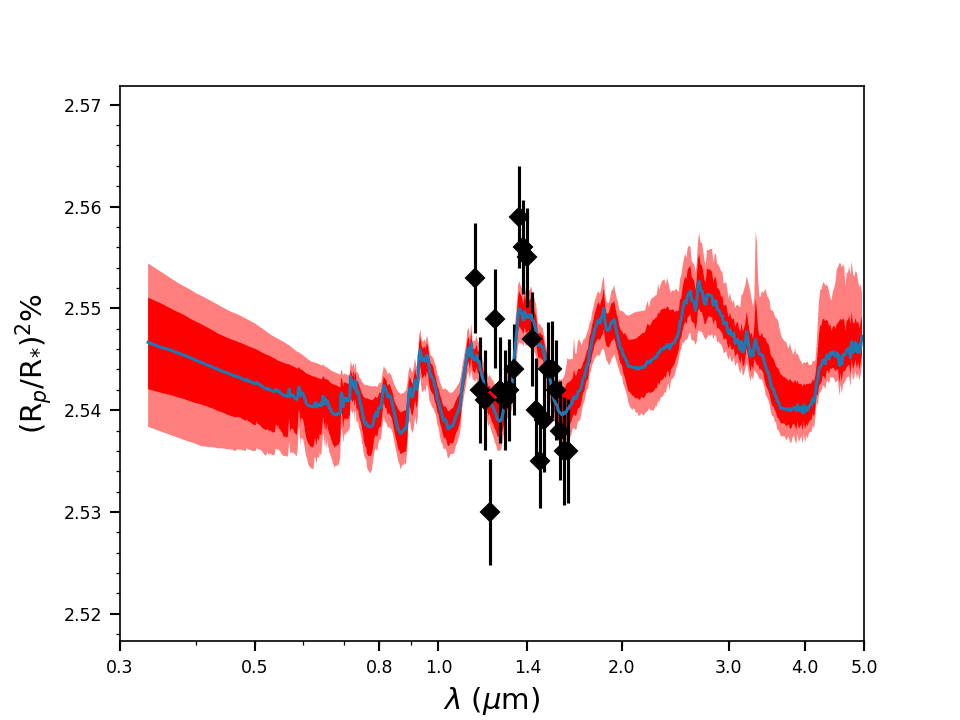

In [15]:
wlgrid, y_meas, err, y_binned_array, wno, y_mod_array=pickle.load(open('./OUTPUT/spectral_samples_trans_dyn_wfc3_free.pic','rb'))
y_median=np.zeros(wno.shape[0])
y_high_1sig=np.zeros(wno.shape[0])
y_high_2sig=np.zeros(wno.shape[0])
y_low_1sig=np.zeros(wno.shape[0])
y_low_2sig=np.zeros(wno.shape[0])

for i in range(wno.shape[0]):
    percentiles=np.percentile(y_mod_array[i,:],[4.55, 15.9, 50, 84.1, 95.45])
    y_low_2sig[i]=percentiles[0]
    y_low_1sig[i]=percentiles[1]
    y_median[i]=percentiles[2]
    y_high_1sig[i]=percentiles[3]
    y_high_2sig[i]=percentiles[4]
    
    
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter

ymin=np.min(y_meas)*1E2*0.995
ymax=np.max(y_meas)*1E2*1.005
fig1, ax=subplots()
xlabel('$\lambda$ ($\mu$m)',fontsize=14)
ylabel('(R$_{p}$/R$_{*}$)$^{2} \%$',fontsize=14)
minorticks_on()


#for i in range(20): plot(wlgrid, y_binned_array[:,i]*100.,alpha=0.5,color='red')
#for i in range(20): plot(1E4/wno, y_mod_array[:,i]*100.,alpha=0.5,color='red')

fill_between(1E4/wno[::-1],y_low_2sig[::-1]*100,y_high_2sig[::-1]*100,facecolor='r',alpha=0.5,edgecolor='None')  
fill_between(1E4/wno[::-1],y_low_1sig[::-1]*100,y_high_1sig[::-1]*100,facecolor='r',alpha=1.,edgecolor='None')  


errorbar(wlgrid, y_meas*100, yerr=err*100, xerr=None, fmt='Dk')
plot(1E4/wno, y_median*1E2)
ax.set_xscale('log')
ax.set_xticks([0.3, 0.5,0.8,1,1.4, 2, 3, 4, 5])
ax.axis([0.3,5.0,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=5,width=1,labelsize='small',which='major')
savefig('./plots/dyn_transmission_spectrum_fits_WFC3_FREE.pdf',fmt='pdf')
show()
#close()

    

# Doing all of that again, but with PyMultiNest ------------------------------------- 
PyMultiNest (a python wrapper for MultiNest): Buchner et al. 2014 <br>
Paper: https://ui.adsabs.harvard.edu/abs/2014A%26A...564A.125B/abstract)<br>
GitHub: https://johannesbuchner.github.io/PyMultiNest/<br><br>
MultiNest: Feroz & Hobson 2008<br>
Paper: https://ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F/abstract<br>
GitHub:https://github.com/farhanferoz/MultiNest<br><br>
It is highly advised that you read the relevant sections of these papers and online documentation

# First have to install MultiNest (a bunch of Fortran, C) and PyMultiNest
While dynesty is easy to install and use, it's not quite as an efficient as a sampler as MultiNest/PyMultiNest (at least that I have found).  Here we will re-do the above retrieval, but with the PyMultiNest package. The MultiNest package is readily parallelizeble on any compute cluster or multicore desktop/laptop (using mpi).  Be forewarned, installing PyMultiNest can be a challenge as it is a combination of python, c, and fortran codes. Most compute cluster admins are able to install this package (both within slurm and torque).  Below I outline the steps that I took on my 2016 MacBook Pro with High Sierra (10.13.6) based on a combination of https://www.astrobetter.com/wiki/MultiNest+Installation+Notes and https://exoai.github.io/software/taurex/installation.

Assuming you have some version of MacPorts, execute the following in this order from a terminal command line (note this can take several hours):
1. sudo port install gcc5
2. sudo port select --set gcc mp-gcc5
3. sudo port install cmake
4. sudo port install openblas +gcc5
5. sudo port install openmpi +gcc5
6. sudo port select --set mpi openmpi-mp-fortran
7. git clone https://github.com/JohannesBuchner/MultiNest.git
8. cd MultiNest/build/
9. cmake ..
10. make
11. sudo make install
12. git clone https://github.com/JohannesBuchner/PyMultiNest.git 
13. cd PyMultiNest 
14. python setup.py install





# Time To Run It
OK, time to run. Sorry, you will have to leave the comfort and safety of this notebook, but I'll walk you through it here.  We will be using "mpirun" to run on your multiple processors on your laptop which I have not figured out how to do from a jupyter notebook (maybe you can use spawn or whatever, if your ambitious). 

# STEP 1
 Open the routine "call_pymultinest_transmission.py". Have a look, digest it, read the comments, etc.  It should look farily similar to the above dynesty fundtions (e.g., a loglikelihood, prior cube, etc.).  No need to modify anything for this. However, you would modify this script if you wanted to add/remove particular parameters or change the wavelength/wavenumber ranch of the run. 
 
# STEP 2 (really a pseudostep)
Go to the folder (in terminal) where you have downloaded the CHIMERA code (mainly, where "call_pymultinest_transmission.py" lives).  To run using one CPU, simpley type the following:

python call_pymultinest_transmission_wfc3_FREE.py

Wait a minute.  You should see some useless unimportant error messages pop out followed by "Cross-sections Loaded" followed shortely there after by


$*************************$<br>
MultiNest v3.10<br>
Copyright Farhan Feroz & Mike Hobson<br>
Release Jul 2015<br><br>
no. of live points =  500<br> 
dimensionality =    8<br> 
$*************************$ <br>
Starting MultiNest<br>
generating live points



$------------------$

Eventually (a few minutes) you whould see more output:

 live points generated, starting sampling
<br>
Acceptance Rate:                        0.998185<br>
Replacements:                                550<br>
Total Samples:                               551<br>
Nested Sampling ln(Z):            $**************$<br>
Acceptance Rate:                        0.977199<br>
Replacements:                                600<br>
Total Samples:                               614<br>
Nested Sampling ln(Z):            $**************$<br>
Acceptance Rate:                        0.965825<br>
Replacements:                                650<br>
Total Samples:                               673<br>
Nested Sampling ln(Z):            $**************$<br>
Acceptance Rate:                        0.939597<br>
Replacements:                                700<br>
Total Samples:                               745<br>
Nested Sampling ln(Z):            $**************$<br>



Do not be alarmed by the $*****$. It just means that there are too many digits to print out for the inital ln(Z) values.  Eventually normalish looking numbers (usually negative) print out here.  Ok, feel free to kill this now, because we will use mpi to make it faster.

# STEP 3
To do mpi, if everything installed correctly, you just need to type the following into the same command line: <br><br>
mpirun -np 4 python call_pymultinest_transmission_wfc3_FREE.py<br><br>
Note, you can use more than 4 cpu's/cores if your computer has them. Use as many as you have. Now, just wait. You should see similar output as for the single cpu, ubt at a faster rate.  For the default setup, with 4 cpu's, this takes $\sim$1hr 10 min (15452 calls). When it is done it will print out this:<br>

 ln(ev)=  -25.249086782326863      +/-  0.12562433089471531    
 Total Likelihood Evaluations:        15452<br>
 Sampling finished. Exiting MultiNest<br>
  analysing data from ./pmn$_$transmission/template_.txt<br>
  analysing data from ./pmn$_$transmission/template_.txt<br>
  analysing data from ./pmn$_$transmission/template_.txt<br>
  analysing data from ./pmn$_$transmission/template_.txt<br>




# STEP 4
When this is done, it is time to plot. Open the routine, "plot_PMN_transmission.py".  This will make the usual obnoxious corner plots, a reconstructed "TP" profile (which is kind of meaningless), and will generate sample spectra from random parameter vectors drawn from the posterior.  This last part takes some time.  When this is complete a nice 1-,2-sigma spectral spread plot will pop up.  Feel free to manipulate this to make plots to your liking.  Note, the spectral draws will be saved as a python pickle so that you can twiddle with plot adjustments without haveing to regenerate that each time.  

That's it! You are done!  So after having worked throught his notebook you should feel comfortable playing around with the forward model to gain an understanding of how each parameter influences the spectrum, comfortable running both the dynesty and pymultinest samplers, and plotting up standard output/results.  Good luck.  Note, there is no warrenty, if you get an unpysical answer, that's on you =)

Feel free to move onto the emission tutorial!





